# Дисперсионный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Загрузка данных

In [2]:
df = pd.read_csv('insurance.csv')

print("Описание:")
display(df.describe())

print(f'Пропуски:\n{df.isna().sum()}')
data = df.dropna()
data['sex'] = data['sex'].map({'female':0, 'male':1})
data['smoker'] = data['smoker'].map({'no':0, 'yes':1})

print("Количество дублированных записей:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Количество дублированных записей после очистки:", data.duplicated().sum())

data.head()

Описание:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Пропуски:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Количество дублированных записей: 1
Количество дублированных записей после очистки: 0


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


### Однофакторный ANOVA тест для проверки влияния региона на индекс массы тела (scipy)

In [3]:
# Сгруппируем данные bmi по регионам
groups = data.groupby('region').groups
northeast = data['bmi'][groups['northeast']]
northwest = data['bmi'][groups['northwest']]
southeast = data['bmi'][groups['southeast']]
southwest = data['bmi'][groups['southwest']]

# выполняем ANOVA
print(sts.f_oneway(northeast, northwest, southeast, southwest))
print("p-значение меньше уровня значимости, мы можем отклонить нулевую гипотезу и сделать вывод, \
что у нас есть достаточно доказательств, чтобы сказать, что по крайней мере одно из средних групп отличается от других (не все средние значения групп равны)")
print("Значит фактор регион оказывает статистически значимое влияние на индекс массы тела")


F_onewayResult(statistic=39.48593864487439, pvalue=1.9087293927440606e-24)
p-значение меньше уровня значимости, мы можем отклонить нулевую гипотезу и сделать вывод, что у нас есть достаточно доказательств, чтобы сказать, что по крайней мере одно из средних групп отличается от других (не все средние значения групп равны)
Значит фактор регион оказывает статистически значимое влияние на индекс массы тела


### Однофакторный ANOVA тест для проверки влияния региона на индекс массы тела (statsmodels)

In [4]:
model = ols('bmi ~ region', data=data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print("Результат аналогичный (см. region - PR(>F)")

                sum_sq      df          F        PR(>F)
region     4057.813904     3.0  39.485939  1.908729e-24
Residual  45662.381091  1333.0        NaN           NaN
Результат аналогичный (см. region - PR(>F)


### t-критерий Стьюдента и поправвка Бонферрони
Используем их для определения того, в каких группах есть влияние на показатель 'bmi'. Так как мы имеем 6 сравнений, поэтому m = 6. Значит необходимо pvalue уменьшить в 6 раз. То есть можно сказать, что критическое значение ɑ, она же поправка Бонферрони, становится 0.008(3)

In [5]:
region_pairs = []
regions = ['northeast', 'northwest', 'southeast', 'southwest']

for region1 in range(3):
    for region2 in range(region1 + 1, 4):
        region_pairs.append((regions[region1], regions[region2]))

# t-тест
for region1, region2 in region_pairs:
    print(f"Пара {region1}, {region2}:")
    result = sts.ttest_ind(data['bmi'][groups[region1]], data['bmi'][groups[region2]])
    print(result)
    if result[1] < 0.0083:
        print("Нулевая гипотеза отвергается. Наблюдается различия в значениях 'bmi'")
    else:
        print("Нулевая гипотеза принимается. Различий в значениях 'bmi' НЕ наблюдается")
    print()

Пара northeast, northwest:
Ttest_indResult(statistic=-0.05038637314068614, pvalue=0.9598300701853016)
Нулевая гипотеза принимается. Различий в значениях 'bmi' НЕ наблюдается

Пара northeast, southeast:
Ttest_indResult(statistic=-8.790905562598699, pvalue=1.186014937424813e-17)
Нулевая гипотеза отвергается. Наблюдается различия в значениях 'bmi'

Пара northeast, southwest:
Ttest_indResult(statistic=-3.1169000930045923, pvalue=0.0019086161671573074)
Нулевая гипотеза отвергается. Наблюдается различия в значениях 'bmi'

Пара northwest, southeast:
Ttest_indResult(statistic=-9.252137489219615, pvalue=2.7504255547794223e-19)
Нулевая гипотеза отвергается. Наблюдается различия в значениях 'bmi'

Пара northwest, southwest:
Ttest_indResult(statistic=-3.289593460501664, pvalue=0.0010577505931067947)
Нулевая гипотеза отвергается. Наблюдается различия в значениях 'bmi'

Пара southeast, southwest:
Ttest_indResult(statistic=5.908373821545118, pvalue=5.4374009639680636e-09)
Нулевая гипотеза отвергается

### Пост-хок тесты Тьюки
Тесты позволяют дать ответ на вопрос: благодаря каким различиям влияние фактора на данные оказалось значимым? Заметим, что, как и в прошлом случае различие в значениях 'bmi' есть у всех пар за исключением northwest-northeast. Можно сделать аналогичные выводы. В данной части работы выодится график со среднимми значениями и их доверительными интервалами.

И мы можем наблюдать, что доверительные интервалы у первой пары (см. таблицу) перекрываются, поэтому пост-хок тесты показали, что различия между ними не существенные

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.022,0.9,-1.1609,1.2048,False
northeast,southeast,4.1825,0.001,3.0326,5.3324,True
northeast,southwest,1.4231,0.0107,0.2412,2.605,True
northwest,southeast,4.1605,0.001,3.0106,5.3104,True
northwest,southwest,1.4011,0.0125,0.2192,2.5831,True
southeast,southwest,-2.7594,0.001,-3.9083,-1.6104,True


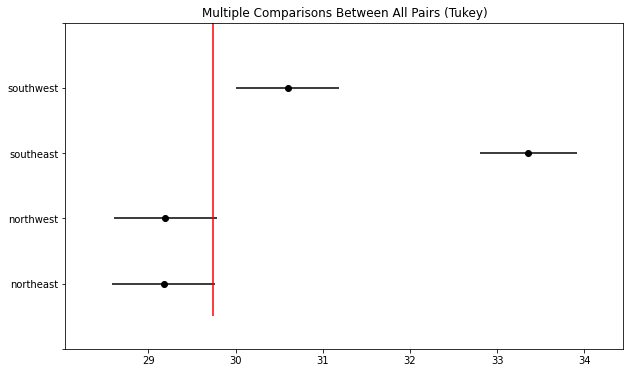

In [6]:
tukey = pairwise_tukeyhsd(endog = data['bmi'], groups=data['region'], alpha = 0.05)
tukey.plot_simultaneous()
plt.vlines(x = data['bmi'][groups['northwest']].mean() + 0.55, ymin=-0.5, ymax = 4.5, color='red')
tukey.summary()


### Двухфакторный ANOVA тест
Выполним для проверки влияния региона и пола на индекс массы тела (BMI), используя функцию anova_lm() из библиотеки statsmodels

In [7]:
# выполняем ANOVA
model = ols('bmi ~ C(region) + C(sex) + C(region):C(sex)', data=data).fit()
sm.stats.anova_lm(model, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
C(region),3.0,4057.813904,1352.604635,39.593241,1.660041e-24
C(sex),1.0,85.359929,85.359929,2.498643,1.141824e-01
C(region):C(sex),3.0,175.040197,58.346732,1.707917,1.635099e-01
Residual,1329.0,45401.980965,34.162514,NaN,NaN


Поскольку p-значение для региона меньше 0.05, это означает, что данный фактор оказывает статистически значимое влияение на значение индекса массы тела.

Однако p-значения для пола и эффекта взаимодействия двух факторов составляет не менее 0.05, что говорит нам об отсутствии значительного эффекта пол на индекс массы тела, а также эффекта взаимодействия между полом и регионом

### Пост-хок тесты Тьюки для двухфакторного анализа

group1,group2,meandiff,p-adj,lower,upper,reject
northeast / 0,northeast / 1,-0.2998,0.9,-2.2713,1.6717,False
northeast / 0,northwest / 0,-0.0464,0.9,-2.0149,1.9222,False
northeast / 0,northwest / 1,-0.2133,0.9,-2.194,1.7673,False
northeast / 0,southeast / 0,3.3469,0.001,1.4093,5.2846,True
northeast / 0,southeast / 1,4.6657,0.001,2.7627,6.5686,True
northeast / 0,southwest / 0,0.7362,0.9,-1.2384,2.7107,False
northeast / 0,southwest / 1,1.8051,0.101,-0.1664,3.7767,False
northeast / 1,northwest / 0,0.2534,0.9,-1.709,2.2158,False
northeast / 1,northwest / 1,0.0864,0.9,-1.8882,2.061,False
northeast / 1,southeast / 0,3.6467,0.001,1.7153,5.5782,True


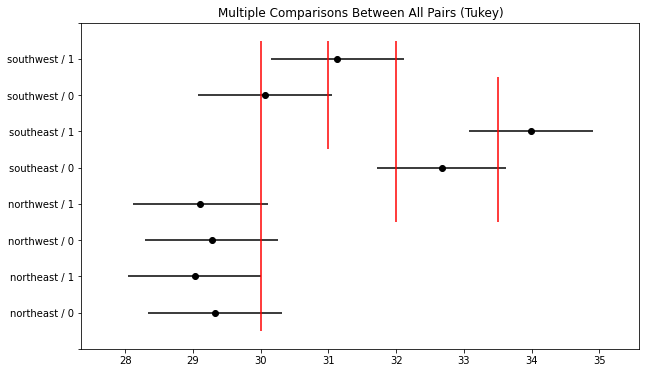

In [8]:
data ['combination'] = data.region + ' / ' + data.sex.astype('str')
tukey = pairwise_tukeyhsd(endog = data['bmi'], groups = data['combination'], alpha = 0.05)
tukey.plot_simultaneous()
plt.vlines(x = 30 , ymin=-0.5, ymax = 7.5, color='red')
plt.vlines(x = 31 , ymin=4.5, ymax = 7.5, color='red')
plt.vlines(x = 32 , ymin=2.5, ymax = 7.5, color='red')
plt.vlines(x = 33.5 , ymin=2.5, ymax = 6.5, color='red')
tukey.summary()